In [1]:
import math
import numpy as np
import string
from datetime import datetime
import sys
import os
from astropy.table import Table
import random
import glob

import matplotlib.pyplot as plt;
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
import seaborn as sns;
from scipy import stats
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
tf.logging.set_verbosity(tf.logging.ERROR)
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

np.random.seed(12)

import SetPub
SetPub.set_pub()


# https://github.com/dunovank/jupyter-themes
# jt -t onedork -fs 14 -altp -tfs 14 -nfs 14 -ofs 14 -cellw 90% -T -N -kl

# # import jtplot submodule from jupyterthemes
# from jupyterthemes import jtplot

# # currently installed theme will be used to
# # set plot style if no arguments provided
# jtplot.style()

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nramachandra

In [2]:
print(20*'=~')
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
print(20*'=~')

=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~
=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~=~


In [3]:

def ReadCosmos(path_program = '../../Data/fromGalaxev/photozs/datasets/'):


    fileIn = path_program + 'new_cosmos_sdss/all_col_sdss.npy'
    TrainfilesAll = np.load(fileIn)

    fileInZ = path_program + 'new_cosmos_sdss/redshifts.npy'
    TrainZAll = np.load(fileInZ)

    Trainfiles = np.empty(shape=(TrainfilesAll.shape[0]*TrainfilesAll.shape[1], TrainfilesAll.shape[2] + 1))

    for galID in range(TrainfilesAll.shape[0]):
        trainfiles100 = np.append(TrainfilesAll[galID, :, :], TrainZAll[:, None], axis=1)
        Trainfiles[galID*TrainfilesAll.shape[1]: galID*TrainfilesAll.shape[1] + TrainfilesAll.shape[1]] = trainfiles100


    fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
    Testfiles = np.load(fileIn)



    TrainshuffleOrder = np.arange(Trainfiles.shape[0])
    np.random.shuffle(TrainshuffleOrder)

    Trainfiles = Trainfiles[TrainshuffleOrder]


    TestshuffleOrder = np.arange(Testfiles.shape[0])
    np.random.shuffle(TestshuffleOrder)

    Testfiles = Testfiles[TestshuffleOrder]


    X_train = Trainfiles[:num_train, :-1]  # color mag
    X_test = Testfiles[:num_test, 1:]  # color mag

    y_train = Trainfiles[:num_train, -1]  # spec z
    y_test = Testfiles[:num_test, 0] # spec z

    ############## THINGS ARE SAME AFTER THIS ###########

    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin



In [4]:
def ReadCosmosDraw(path_program = '../../Data/fromGalaxev/photozs/datasets/', num_magI_draws = 4):

    fileInMagI = path_program + 'new_cosmos_sdss/all_prior_mag_sdss.npy'
    fileInColors = path_program + 'new_cosmos_sdss/all_col_sdss.npy'

    TrainfilesColors = np.load(fileInColors)
    TrainfilesMagI = np.load(fileInMagI)


    magI_low = 15
    magI_high = 23

    fileInZ = path_program + 'new_cosmos_sdss/redshifts.npy'
    TrainZAll = np.load(fileInZ)

    Trainfiles = np.zeros(shape=(num_magI_draws*TrainfilesColors.shape[0]*TrainfilesColors.shape[1], TrainfilesColors.shape[2] + 2))

    for galID in range(TrainfilesColors.shape[0]):

        TrainfilesMagI[galID, :, 1][TrainfilesMagI[galID, :, 1] < magI_low] = magI_low
        TrainfilesMagI[galID, :, 0][TrainfilesMagI[galID, :, 0] > magI_high] = magI_high

        imag = np.random.uniform(low=TrainfilesMagI[galID, :, 0], high=TrainfilesMagI[galID, :, 1], size=(num_magI_draws, np.shape(TrainfilesMagI[galID, :, 1])[0])).T

        for mag_degen in range(num_magI_draws):
            colors_mag = np.append(TrainfilesColors[galID, :, :], imag[:, mag_degen][:, None], axis=1)
            trainfiles100 = np.append(colors_mag, TrainZAll[:, None], axis=1)

            train_ind_start = galID*TrainfilesColors.shape[1] + mag_degen*TrainfilesColors.shape[0]*TrainfilesColors.shape[1]
            train_ind_end = galID*TrainfilesColors.shape[1] + mag_degen*TrainfilesColors.shape[0]*TrainfilesColors.shape[1] + TrainfilesColors.shape[1]

            Trainfiles[train_ind_start: train_ind_end] = trainfiles100

    fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
    Testfiles = np.load(fileIn)


    TrainshuffleOrder = np.arange(Trainfiles.shape[0])
    np.random.shuffle(TrainshuffleOrder)

    Trainfiles = Trainfiles[TrainshuffleOrder]


    TestshuffleOrder = np.arange(Testfiles.shape[0])
    np.random.shuffle(TestshuffleOrder)

    Testfiles = Testfiles[TestshuffleOrder]

    #
    # X_train = Trainfiles[:num_train, :-1]  # color mag
    # X_test = Testfiles[:num_test, 1:]  # color mag
    #
    # y_train = Trainfiles[:num_train, -1]  # spec z
    # y_test = Testfiles[:num_test, 0] # spec z
    #
    # ############## THINGS ARE SAME AFTER THIS ###########
    #
    # ## rescaling xmax/xmin
    # xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    # xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)
    #
    # X_train = (X_train - xmin) / (xmax - xmin)
    # X_test = (X_test - xmin) / (xmax - xmin)
    #
    # #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue
    #
    # ymax = np.max([y_train.max(), y_test.max()])
    # ymin = np.min([y_train.min(), y_test.min()])
    #
    # y_train = (y_train - ymin) / (ymax - ymin)
    # y_test = (y_test - ymin) / (ymax - ymin)
    #
    # return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin
    #
    # ############# THINGS ARE SAME AFTER THIS ###########

    X_train = Trainfiles[:num_train, :-1]  # color mag
    X_test = Trainfiles[num_train + 1: num_train + num_test, :-1]  # color mag


    y_train = Trainfiles[:num_train, -1]   # spec z
    y_test = Trainfiles[num_train + 1: num_train + num_test, -1]  # spec z

    ############## THINGS ARE SAME AFTER THIS ###########

    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin


In [5]:
print(tf.__version__)

1.14.0


In [6]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)


def neural_network_mod():
    """
    loc, scale, logits = NN(x; theta)

    Args:
      X: Input Tensor containing input data for the MDN
    Returns:
      locs: The means of the normal distributions that our data is divided into.
      scales: The scales of the normal distributions that our data is divided
        into.
      logits: The probabilities of ou categorical distribution that decides
        which normal distribution our data points most probably belong to.
    """
    X = tf.placeholder(tf.float64,name='X',shape=(None,D))
    # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 32, activation=tf.nn.relu)
    net = tf.layers.dense(net, 16, activation=tf.nn.relu)
    net = tf.layers.dense(net, 8, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    outdict= {'locs':locs, 'scales':scales, 'logits':logits}
    hub.add_signature(inputs=X,outputs=outdict)

    return locs, scales, logits


def mixture_model(X,Y,learning_rate=1e-3,decay_rate=.95,step=1000,train=True):
    if train:
        dict = neural_network(tf.convert_to_tensor(X),as_dict=True)
    else:
        dict = neural_network_t(tf.convert_to_tensor(X),as_dict=True)
    locs = dict['locs'] ; scales = dict['scales'] ; logits = dict['logits']
    cat = tfd.Categorical(logits=logits)
    components = [tfd.Normal(loc=loc, scale=scale) for loc, scale
                  in zip(tf.unstack(tf.transpose(locs)),
                         tf.unstack(tf.transpose(scales)))]

    y = tfd.Mixture(cat=cat, components=components)
    #define loss function
    log_likelihood = y.log_prob(Y)
    # log_likelihood = -tf.reduce_sum(log_likelihood/(1. + y_train)**2 )
    y_mean = np.median(Y)
    log_likelihood = -tf.reduce_sum(log_likelihood)
    #log_likelihood = -tf.reduce_sum(log_likelihood*(y_mean-y_train)**4 )
    if train:
        global_step = tf.Variable(0, trainable=False)
        decayed_lr = tf.train.exponential_decay(learning_rate,
                                        global_step, step,
                                        decay_rate, staircase=True)
        optimizer = tf.train.AdamOptimizer(decayed_lr)
        train_op = optimizer.minimize(log_likelihood)
        evaluate(tf.global_variables_initializer())
        return log_likelihood, train_op, logits, locs, scales
    else:
        evaluate(tf.global_variables_initializer())
        return log_likelihood, logits, locs, scales

def train(log_likelihood,train_op,n_epoch):
    train_loss = np.zeros(n_epoch)
    test_loss = np.zeros(n_epoch)
    for i in range(n_epoch):
        _, loss_value = evaluate([train_op, log_likelihood])
        train_loss[i] = loss_value
    plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train Loss')
    # plt.savefig('../Plots/T_loss_function.pdf')
    return train_loss

def get_predictions(logits,locs,scales):
    pred_weights, pred_means, pred_std = evaluate([tf.nn.softmax(logits), locs, scales])
    return pred_weights, pred_means, pred_std

def testing(X_test,y_test):

    log_likelihood,  logits, locs, scales = mixture_model(X_test,y_test,train=False)
    #_, loss_value = evaluate([train_op, log_likelihood])
    pred_weights, pred_means, pred_std = get_predictions(logits,locs,scales)
    return pred_weights, pred_means, pred_std

In [7]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """
  # x = np.linspace(-10.5, 10.5, 250)
  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
      ax.plot(x, temp, label='Normal ' + str(i), alpha =0.3)
  ax.plot(x, final, label='Mixture of Normals ' + label)
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, train=True):
    np.random.seed(12)
#     np.random.seed(12)

#     if train:
#         obj = [random.randint(0,num_train-1) for x in range(num)]
#     else:
#         obj = [random.randint(0,num_test-1) for x in range(num)]
#     #obj = [93, 402, 120,789,231,4,985]
    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
    #obj = [93, 402, 120,789,231,4,985]
    
    print(obj)
#     fig, axes = plt.subplots(nrows=num, ncols=1, sharex = True, figsize=(8, 7), num='PDFs')
    allfs = []
    for i in range(len(obj)):
        fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i],
                    pred_std[obj][i], axes[i], comp=False)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
#         axes[i].text(0.3, 4.0, 'ID: ' +str(obj[i]), horizontalalignment='center', verticalalignment='center')

#     plt.xlabel(r' rescaled[$z_{pred}]$', fontsize = 19)
    plt.xlabel(r'$z_{\rm pred}]$', fontsize = 22)
    plt.ylabel('$PDF$', fontsize = 22)


    # plt.savefig('../Plots/T_pdfs.pdf')
#     plt.show()

def plot_pred_mean(pred_means,pred_weights,pred_std,ymax,ymin,y,select='no'):
    y_pred = np.sum(pred_means*pred_weights, axis = 1)
    y_pred_std = np.sum(pred_std*pred_weights, axis = 1)

    plt.figure(22, figsize=(9,8))

    #ymax=1
    #ymin=0
    # if select == 'yes':
    #     y_pred = y_pred[obj]
    #     y_train = y_train[obj]
    #     y_pred_std = y_pred_std[obj]

    # plt.scatter(y_test, y_pred, facecolors='k', s = 1)

    # plt.errorbar( (ymax - ymin)*(y_train)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    plt.errorbar( (ymax - ymin)*(y)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(y_pred_std), fmt='o', ms = 2, alpha = 0.1)

    #switched
    #plt.errorbar(  (ymax - ymin)*(y_pred)+ymin, (ymax - ymin)*(y_train)+ymin, yerr= (ymax - ymin)*(y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

    #plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
    plt.plot((ymax - ymin)*(y)+ymin, (ymax - ymin)*( y)+ymin, 'k')

    plt.ylabel(r'$z_{pred}$', fontsize = 19)
    plt.xlabel(r'$z_{true}$', fontsize = 19)
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title('weight x mean')
    plt.tight_layout()
    # plt.savefig('../Plots/T_pred_mean.pdf')
#     plt.show()

def plot_pred_peak(pred_means,pred_weights,pred_std,ymax,ymin,y,select='no'):
    def peak(weight,sigma):
        return weight/np.sqrt(2*np.pi*sigma**2)

    peak_max = np.argmax(peak(pred_weights,pred_std),axis=1)
    y_pred = np.array([pred_means[i,peak_max[i]] for i in range(len(y))])
    y_pred_std = np.array([pred_std[i,peak_max[i]] for i in range(len(y))])
    plt.figure(24, figsize=(9, 8))
    # if select == 'yes':
    #     y_pred = y_pred[obj]
    #     y_train = y_train[obj]
    #     y_pred_std = y_pred_std[obj]
    # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
    # plt.errorbar((ymax - ymin)*(y_train)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
    #   y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

    plt.errorbar((ymax - ymin)*(y)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
      y_pred_std), fmt='o', ms = 2, alpha = 0.1)


    #plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
    plt.plot((ymax - ymin)*(y_test)+ymin, (ymax - ymin)*(y_test)+ymin, 'k')
    plt.ylabel(r'$z_{pred}$', fontsize = 19)
    plt.xlabel(r'$z_{true}$', fontsize = 19)
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title('highest peak')
    plt.tight_layout()
#     plt.show()

def plot_pred_weight(pred_means,pred_weights,pred_std,ymax,ymin,y,select='no'):
    weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???

    y_pred = np.array([pred_means[i,weight_max[i]] for i in range(len(y))])
    y_pred_std = np.array([pred_std[i,weight_max[i]] for i in range(len(y))])

    plt.figure(29, figsize=(9, 8))
    # if select == 'yes':
    #     y_pred = y_pred[obj]
    #     y_train = y_train[obj]
    #     y_pred_std = y_pred_std[obj]

    # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
    # plt.errorbar((ymax - ymin)*(y_train)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
    #   y_pred_std), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)

    plt.errorbar((ymax - ymin)*(y)+ymin, (ymax - ymin)*(y_pred)+ymin, yerr= (ymax - ymin)*(
      y_pred_std), fmt='o', ms = 2, alpha = 0.1)

    #plt.text(0.2, 0.9, train_datafile + ' trained', horizontalalignment='center', verticalalignment='center')
    plt.plot((ymax - ymin)*(y_test)+ymin, (ymax - ymin)*(y_test)+ymin, 'k')
    plt.ylabel(r'$z_{pred}$', fontsize = 19)
    plt.xlabel(r'$z_{true}$', fontsize = 19)
    #plt.xlim([0,1])
    #plt.ylim([0,1])
    plt.title('highest weight')
    plt.tight_layout()
#     plt.show()


def per_stats(pred_means,pred_weights,pred_std,ymax,ymin,y):
    y_pred = np.sum(pred_means*pred_weights, axis = 1)
    y_pred_std = np.sum(pred_std*pred_weights, axis = 1)
    y_pred = (ymax - ymin)*(y_pred)+ymin
    y_pred_std = (ymax - ymin)*(y_pred_std)
    y = (ymax - ymin)*(y)+ymin
    diff = y_pred-y
    mean_diff = np.mean(diff)
    med_diff = np.median(diff)
    std_diff = np.std(diff)
    mean_sigma = np.mean(y_pred_std)
    med_sigma = np.median(y_pred_std)
    std_sigma = np.std(y_pred_std)
    return mean_diff, med_diff, std_diff, mean_sigma, med_sigma, std_sigma

def plot_cum_sigma(pred_weights,pred_std,ymax,ymin):
    #y_pred_std = np.sum(pred_std*pred_weights, axis = 1)

    weight_max = np.argmax(pred_weights, axis = 1)  ## argmax or max???
    y_pred_std = np.array( [pred_std[i,weight_max[i] ] for i in range(len(pred_weights[0]))])
    y_pred_std = (ymax - ymin)*(y_pred_std)
    plt.figure(222)
    plt.hist(y_pred_std,1000, density=True, histtype='step', cumulative=True)
    plt.xlabel('Sigma')
#     plt.show()

In [8]:
# num_test = 5000
# D = 14 #6  # number of features  (8 for DES, 6 for COSMOS)

In [9]:


n_epochs = 100015 #000 #20000 #100000 #1000 #20000 #20000
# N = 4000  # number of data points  -- replaced by num_trai
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3 # number of mixture components


learning_rate = 5e-2 #5e-3
decay_rate= 0.1 #0.0
step=10


num_train = 800000 #000#00 #800000 #12000000 #800000
num_test = 500 #5000 #params.num_test # 32


syntheticTrain = True # True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

save_mod_2 = '../saved_hubs/'+'sdss_colmag_synthetic_'+str(syntheticTrain)+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)



In [10]:
# n_epochs = 100010 #000 #20000 #100000 #1000 #20000 #20000
# # N = 4000  # number of data points  -- replaced by num_trai
# D = 4 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3 # number of mixture components


# learning_rate = 0.01 #5e-3
# decay_rate= 0.1 #0.0
# step=100


# num_train = 2900000#00 #800000 #12000000 #800000
# num_test = 500 #5000 #params.num_test # 32


# syntheticTrain = True # True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

# save_mod = '../saved_hubs/'+'sdss_Synthetic_'+str(syntheticTrain)+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)





# n_epochs = 100003 #000 #20000 #100000 #1000 #20000 #20000
# # N = 4000  # number of data points  -- replaced by num_trai
# D = 4 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3 # number of mixture components


# learning_rate = 5e-3
# decay_rate= 0.01 #0.0
# step=100


# num_train = 2900000#00 #800000 #12000000 #800000
# num_test = 500 #5000 #params.num_test # 32


# syntheticTrain = True # True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

# save_mod = '../saved_hubs/'+'sdss_Synthetic_'+str(syntheticTrain)+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

# sdss_colmag_synthetic_True_lr_0.05_dr0.1_step10_ne11_k3_nt3300
n_epochs = 11 #000 #20000 #100000 #1000 #20000 #20000
# N = 4000  # number of data points  -- replaced by num_trai
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3 # number of mixture components


learning_rate = 0.05 #5e-3
decay_rate= 0.1 #0.0
step=10


num_train = 3300 #000#00 #800000 #12000000 #800000
num_test = 500 #5000 #params.num_test # 32


syntheticTrain = True # True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

save_mod = '../saved_hubs/'+'sdss_colmag_synthetic_'+str(syntheticTrain)+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)



In [11]:
save_mod

'../saved_hubs/sdss_colmag_synthetic_True_lr_0.05_dr0.1_step10_ne11_k3_nt3300'

In [12]:
save_mod_2

'../saved_hubs/sdss_colmag_synthetic_True_lr_0.05_dr0.1_step10_ne100015_k3_nt800000'

In [13]:
# ! ls ../../../Data/

In [14]:
############ loading data ############

X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadCosmosDraw(path_program = '../../../Data/fromGalaxev/photozs/datasets/', num_magI_draws=4)

# print("Size of features in training data: {}".format(X_train.shape))
# print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (499, 5)
Size of output in test data: (499,)


[331 155 390]


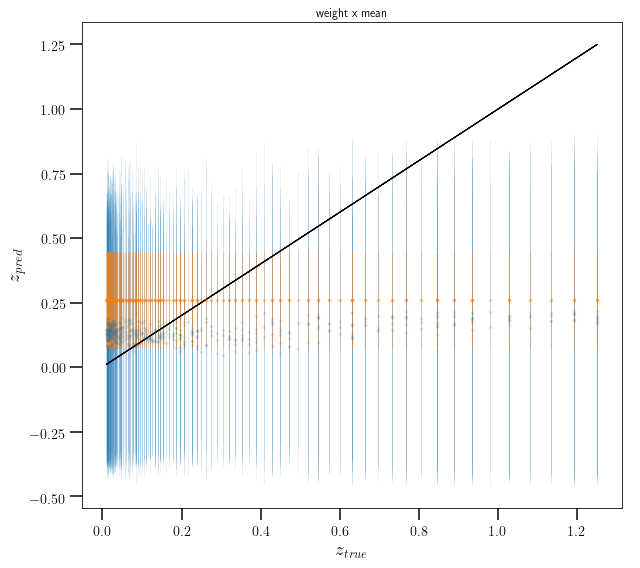

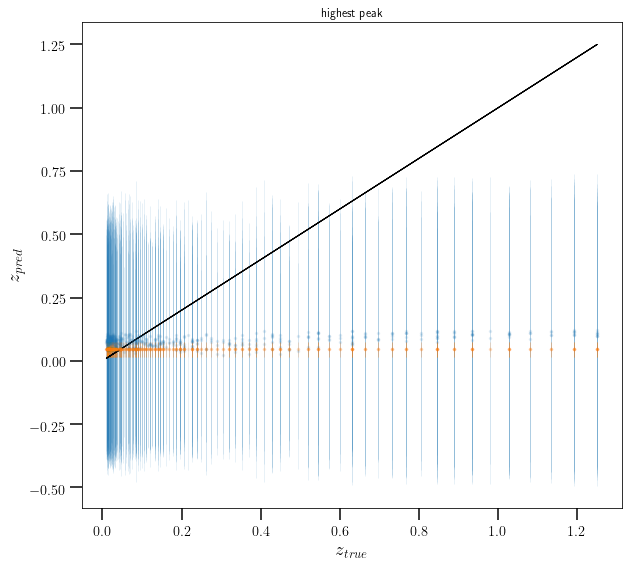

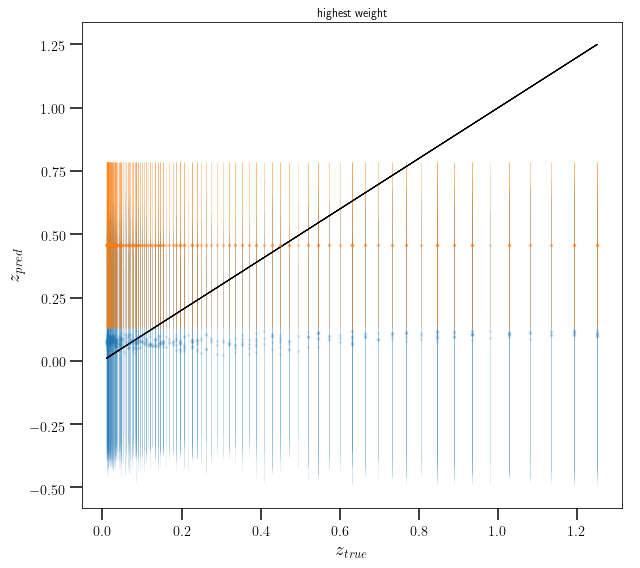

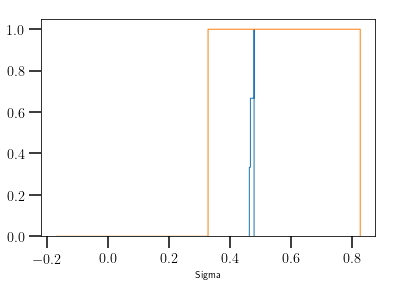

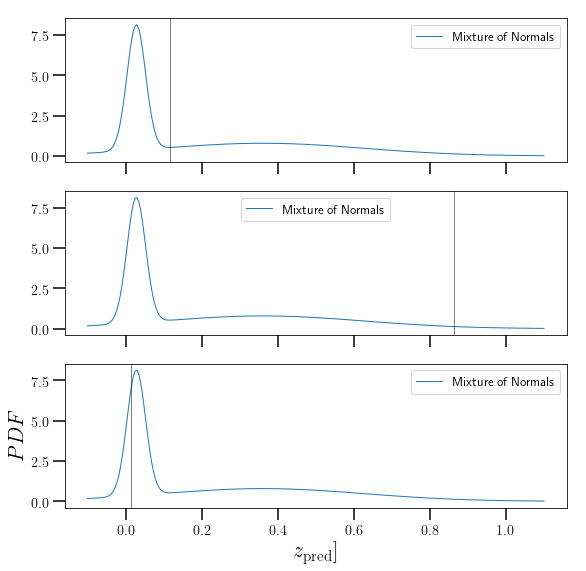

In [15]:
# #### MODEL 1 ####

##load network
neural_network_t = hub.Module(save_mod)

##testing
test_weights, test_means, test_std = testing(X_test,y_test)

##plotting
plot_pred_mean(test_means,test_weights,test_std,ymax,ymin,y_test)
test_mean_diff, test_med_diff, test_std_diff, test_mean_sigma, test_med_sigma, test_std_sigma = per_stats(test_means,test_weights,test_std,ymax,ymin,y_test)
plot_pred_peak(test_means,test_weights,test_std,ymax,ymin,y_test)
plot_pred_weight(test_means,test_weights,test_std,ymax,ymin,y_test)
plot_cum_sigma(test_weights,test_std,ymax,ymin)


##### MODEL 2 ####

##load network
neural_network_t = hub.Module(save_mod_2)

##testing
test_weights_2, test_means_2, test_std_2 = testing(X_test,y_test)

##plotting
plot_pred_mean(test_means_2,test_weights_2,test_std_2,ymax,ymin,y_test)
test_mean_diff_2, test_med_diff_2, test_std_diff_2, test_mean_sigma_2, test_med_sigma_2, test_std_sigma_2 = per_stats(test_means_2,test_weights_2,test_std_2,ymax,ymin,y_test)
plot_pred_peak(test_means_2,test_weights_2,test_std_2,ymax,ymin,y_test)
plot_pred_weight(test_means_2,test_weights_2,test_std_2,ymax,ymin,y_test)
plot_cum_sigma(test_weights_2,test_std_2,ymax,ymin)

## plotting pdfs
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(9, nrows*3), num='pdfs')
# plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, train=False)
plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, train=False)



No handles with labels found to put in legend.
No handles with labels found to put in legend.


[462, 18, 81]
0
1
2


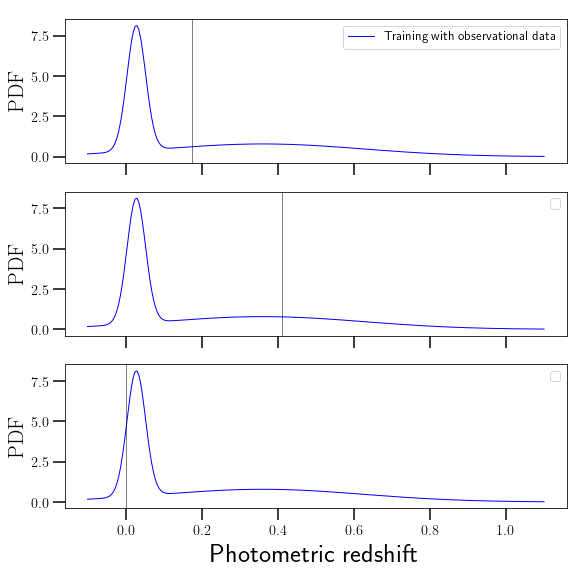

In [16]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', color = '', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """

  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
#       ax.plot(x, temp, label='Normal ' + str(i), alpha =0.6)
      ax.plot(x, temp, 'k--', alpha =0.9)

#       ax.plot(x, temp/final.max(), alpha =0.5)

  ax.plot(x, final,label=label, color = color)
#   ax.plot(x, final/final.max(), label=label, color = color)

    
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, label = '', color = '', train=False, comp = False):
    np.random.seed(132)

    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
#     obj = [462, 667, 81]
#     obj = [462, 102, 81]
    obj = [462, 18, 81]
    
    print(obj)

    allfs = []
    for i in range(len(obj)):
        print(i)
        if (i==0):
            fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = label, color = color, comp=comp)
        else: fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = '', color = color, comp=comp)

        axes[i].set_ylabel(r'${\rm PDF}$', fontsize = 22)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
        

    plt.xlabel('Photometric redshift', fontsize = 26)
    




## plotting pdfs
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(9, nrows*3), num='pdfs')
# plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

In [17]:
y_test2 = y_test ### CHECK THIS AGAIN -- THERE MAY BE ISSUES WITH MIXING TRAINING AND TESTING SETS
ymax2 = ymax
ymin2 = ymin


#### choosing y_pred here -- may not be a good choice
#### cumulative --> y_pred

y_pred = np.sum(test_means*test_weights, axis = 1)
y_pred_std = np.sum(test_std*test_weights, axis = 1)

y_pred_2 = np.sum(test_means_2*test_weights_2, axis = 1)
y_pred_std_2 = np.sum(test_std_2*test_weights_2, axis = 1)


# #### highest weight --> y_pred

# weight_max = np.argmax(test_weights, axis = 1) 

# y_pred = np.array([test_means[i,weight_max[i]] for i in range(len(y_test))])
# y_pred_std = np.array([test_std[i,weight_max[i]] for i in range(len(y_test))])



# weight_max_2 = np.argmax(test_weights_2, axis = 1) 

# y_pred_2 = np.array([test_means_2[i,weight_max_2[i]] for i in range(len(y_test2))])
# y_pred_std_2 = np.array([test_std_2[i,weight_max_2[i]] for i in range(len(y_test2))])


### highest peak --> y_pred

# def peak(weight,sigma):
#     return weight/np.sqrt(2*np.pi*sigma**2)

# peak_max = np.argmax(peak(test_weights,test_std),axis=1)
# y_pred = np.array([test_means[i,peak_max[i]] for i in range(len(y_test))])
# y_pred_std = np.array([test_std[i,peak_max[i]] for i in range(len(y_test))])

# peak_max_2 = np.argmax(peak(test_weights_2,test_std_2),axis=1)
# y_pred_2 = np.array([test_means_2[i,peak_max_2[i]] for i in range(len(y_test2))])
# y_pred_std_2 = np.array([test_std_2[i,peak_max_2[i]] for i in range(len(y_test2))])

In [18]:
def sigmaNMAD(z_spec, z_pho):
    return 1.48*np.median( np.abs( z_pho - z_spec)/(1 + z_spec))
    # else: return 1.48*np.median( np.abs( z_pho - z_spec)/(1 + z_spec),)



def outlierFrac(z_spec, z_pho, threshold = 0.15):
    outliers = z_pho[ (np.abs(z_spec - z_pho)) >= threshold*z_spec ]
    return 100.0*len(outliers)/np.shape(z_pho)[0]


sigmaNMAD_obs_all =  sigmaNMAD( (ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2) )

sigmaNMAD_combine_all =  sigmaNMAD( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred) )


print( 'sigmaNMAD_combine_all ', sigmaNMAD_combine_all  ) ## combine
print( 'sigmaNMAD_obs_all', sigmaNMAD_obs_all ) # obs only


outFr_obs_all = outlierFrac( (ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2), 0.15 )

outFr_combine_all =  outlierFrac( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred) , 0.15)


print( 'outFr_combine_all ', outFr_combine_all  ) ## combine
print( 'outFr_obs_all', outFr_obs_all ) # obs only


sigmaNMAD_obs_all =  sigmaNMAD( (ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 +
                                                                                      y_pred_2) )

sigmaNMAD_combine_all =  sigmaNMAD( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin +
                                                                                      y_pred) )


print( 'sigmaNMAD_combine_all ', sigmaNMAD_combine_all  ) #
# combine
print( 'sigmaNMAD_obs_all', sigmaNMAD_obs_all ) # obs only
####################### model 2 ends ###########################



sigmaNMAD_combine_all  0.15998070905271938
sigmaNMAD_obs_all 0.30082000464814984
outFr_combine_all  93.9879759519038
outFr_obs_all 93.58717434869739
sigmaNMAD_combine_all  0.15998070905271938
sigmaNMAD_obs_all 0.30082000464814984


/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


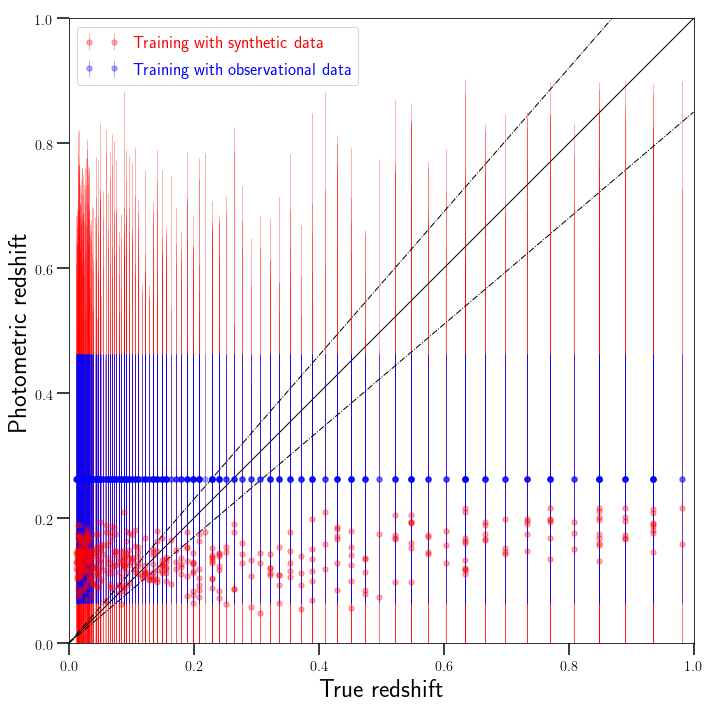

In [19]:
# fig = plt.figure(22)


## Overall mean --- weight * mean
ifPlotWeighted = True

if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10))

    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
      ymin + y_pred_std), fmt='ro', ecolor='r', ms = 5, alpha = 0.3, label = 'Training with synthetic data')


    plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2), yerr= (ymax2 - ymin2)*(
      ymin2 + y_pred_std_2), fmt='bo', ecolor='b', ms = 5, alpha = 0.3, label = 'Training with observational data')

PlotTemplate = False

if PlotTemplate:
    plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_temp), yerr= [(ymax2 - ymin2)*(
          ymin2 + y_temp_p), (ymax2 - ymin2)*(ymin2 + y_temp_p)], fmt='ko', ecolor='k', ms = 5, alpha = 0.3, label = 'Template fitting prediction')

plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.xscale('log')
# plt.yscale('log')


xylims = np.array([0 , 1])
plt.plot(xylims, xylims, 'k')
plt.plot(xylims, 0.85*np.array(xylims), 'k-.')
plt.plot(xylims, 1.15*np.array(xylims), 'k-.')

plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(xylims[0], xylims[1])
plt.ylim(xylims[0], xylims[1])

plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


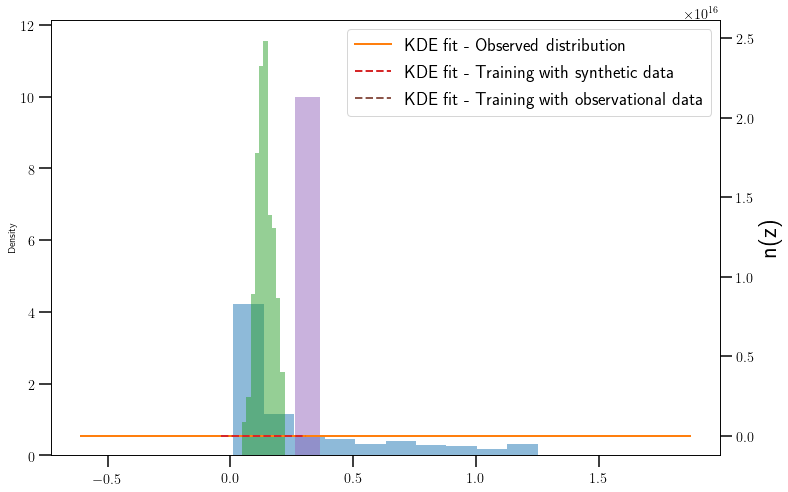

In [20]:
import pandas as pd
s = pd.Series((ymax - ymin)*(ymin + y_test)).add_prefix('Observed distribution')
s1 = pd.Series((ymax - ymin)*(ymin + y_pred)).add_prefix('Training with synthetic data')
s2 = pd.Series((ymax2 - ymin2)*(ymin2 + y_pred_2)).add_prefix('Training with observational data')

plt.figure(12, figsize = (12, 8))

ax = s.plot.hist(alpha=0.5, density=10, label = 'Observed distribution')
ax = s.plot.kde(linewidth = 2, secondary_y=True, label = 'KDE fit - Observed distribution')
ax = s1.plot.hist(alpha=0.5, density=10, label = 'Training with synthetic data')
ax = s1.plot.kde(linewidth = 2,  secondary_y=True, linestyle = '--', label = 'KDE fit - Training with synthetic data')
ax = s2.plot.hist(alpha=0.5, density=10, label = 'Training with observational data')
ax = s2.plot.kde(linewidth = 2, secondary_y=True, linestyle = '--', label = 'KDE fit - Training with observational data')

plt.legend(fontsize = 18)
plt.xlabel('z', fontsize = 24)
plt.ylabel('n(z)',fontsize = 24)
plt.show()

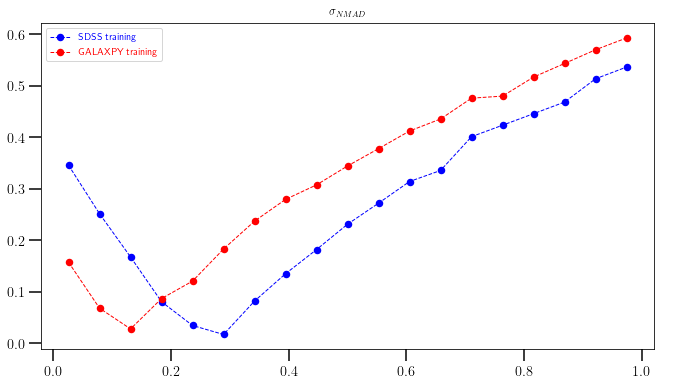

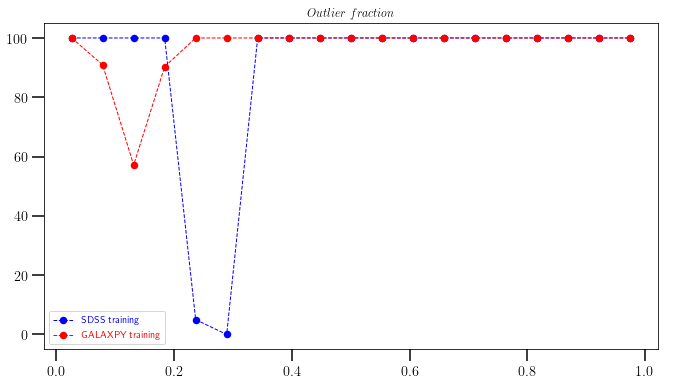

In [21]:
def sigmaNMAD(z_spec, z_pho):
    return 1.48*np.median( np.abs( z_pho - z_spec)/(1 + z_spec))
    # else: return 1.48*np.median( np.abs( z_pho - z_spec)/(1 + z_spec),)

def outlierFrac(z_spec, z_pho, threshold = 0.15):
    outliers = z_pho[ (np.abs(z_spec - z_pho)) >= threshold*z_spec ]
    return 100.0*len(outliers)/np.shape(z_pho)[0]

def MedianProperScore(z_spec, mu_all, sigma_all):
    ## Eq 27 in https://www.tandfonline.com/doi/pdf/10.1198/016214506000001437?needAccess=true
    ## taking median of all scores
    S_all = np.zeros_like(mu_all)
    for comp_i in range(S_all.shape[1]):
        S_all[:, comp_i] = - ((z_spec - mu_all[:, comp_i])/sigma_all[:, comp_i])**2 - np.log(sigma_all[:, comp_i]**2)
    return np.median(S_all, axis = 0)



bins = np.linspace(0, 1, 20)

z_spec = (ymax - ymin)*(ymin + y_test)
z_spec2 = (ymax2 - ymin2)*(ymin2 + y_test2)

z_phot = (ymax - ymin)*(ymin + y_pred)
z_phot2 = (ymax2 - ymin2)*(ymin2 + y_pred_2)

z_spec_digitize = np.digitize( z_spec, bins)
z_spec_digitize2 = np.digitize( z_spec2, bins)

sigmaNMAD_combine = np.zeros(shape=bins.shape[0])
outFr_combine = np.zeros(shape=bins.shape[0])
 

sigmaNMAD_obs = np.zeros(shape=bins.shape[0])
outFr_obs = np.zeros(shape=bins.shape[0])


for ind in range(bins.shape[0] - 1):
    z_spec2_bin_z2 =  z_spec2[ z_spec_digitize2  == ind + 1]
    z_phot2_bin_z2 =  z_phot2[ z_spec_digitize2  == ind + 1]
    sigmaNMAD_obs[ind] =  sigmaNMAD(z_spec2_bin_z2, z_phot2_bin_z2)
    outFr_obs[ind] = outlierFrac(z_spec2_bin_z2, z_phot2_bin_z2, 0.15)
    
    z_spec_bin_z =  z_spec[ np.where(z_spec_digitize  == ind + 1) ]
    z_phot_bin_z =  z_phot[ np.where(z_spec_digitize  == ind + 1)]
    sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
    outFr_combine[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)
    

plt.figure(5232, figsize=(11,6))

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, sigmaNMAD_obs[:bins.shape[0]-1], 'bo--', label = 'SDSS training')
plt.plot(bincenter, sigmaNMAD_combine[:bins.shape[0]-1] , 'ro--', label = 'GALAXPY training')
# plt.xscale('log')
plt.title(r'$\sigma_{NMAD}$')
leg = plt.legend()

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.figure(5233, figsize=(11,6))

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, outFr_obs[:bins.shape[0]-1], 'bo--', label = 'SDSS training')
plt.plot(bincenter, outFr_combine[:bins.shape[0]-1] , 'ro--', label = 'GALAXPY training')
# plt.xscale('log')
plt.title(r'$Outlier$ $fraction$')
leg = plt.legend()

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)
    


[1.869 0.481 0.677]
[ 1.371e+00 -7.497e+00 -8.493e+03]


Text(0.5,1,'$Proper Score $')

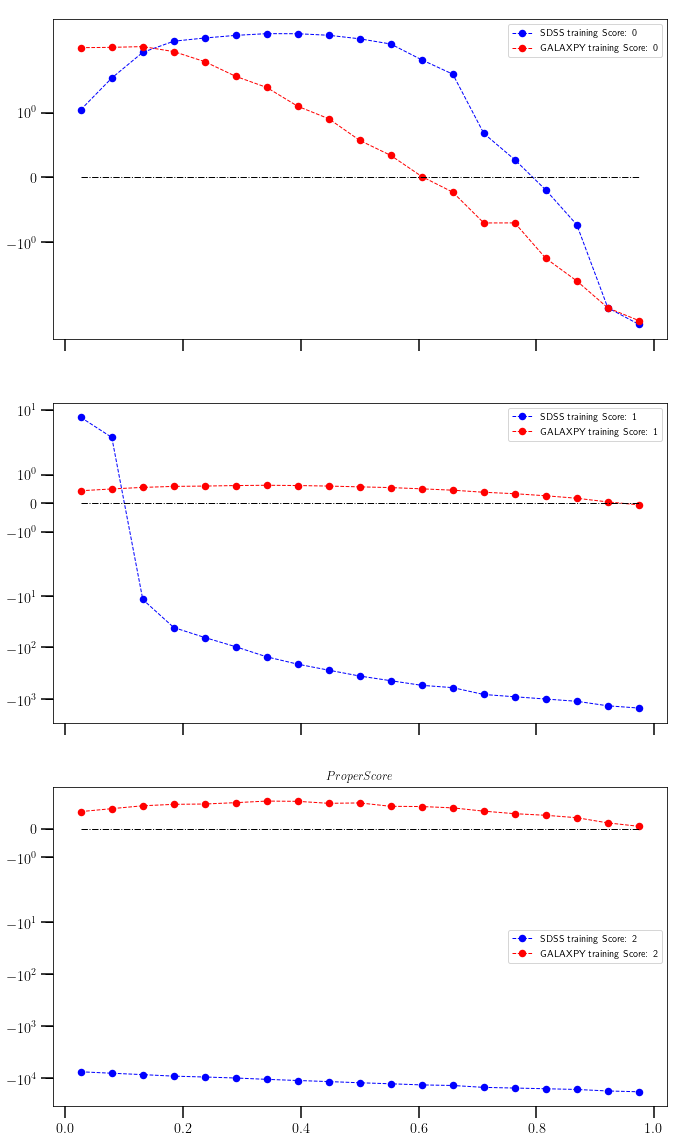

In [22]:
    
MedianProperScore_combine_all = MedianProperScore(z_spec, test_means, test_std)
MedianProperScore_obs_all = MedianProperScore(z_spec2, test_means_2, test_std_2)

print(MedianProperScore_combine_all)
print(MedianProperScore_obs_all)



MedianProperScore_combine0 = np.zeros(shape=(bins.shape[0], K) )
MedianProperScore_obs0 = np.zeros(shape=(bins.shape[0], K) )


for ind in range(bins.shape[0] - 1):
    z_spec2_bin_z2 =  z_spec2[ z_spec_digitize2  == ind + 1]
    test_means_bin_z2 =  test_means_2[ z_spec_digitize2  == ind + 1, :]
    test_std_bin_z2 =  test_std_2[ z_spec_digitize2  == ind + 1, :]
    MedianProperScore_obs0[ind] =  MedianProperScore(z_spec2_bin_z2, test_means_bin_z2, test_std_bin_z2)
    
#     z_spec_bin_z =  z_spec[ np.where(z_spec_digitize  == ind + 1) ]
#     z_phot_bin_z =  z_phot[ np.where(z_spec_digitize  == ind + 1)]
#     sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
#     outFr_combine[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)
    
    z_spec2_bin_z =  z_spec[ z_spec_digitize  == ind + 1]
    test_means_bin_z =  test_means[ z_spec_digitize  == ind + 1, :]
    test_std_bin_z =  test_std[ z_spec_digitize  == ind + 1, :]
    MedianProperScore_combine0[ind] =  MedianProperScore(z_spec2_bin_z, test_means_bin_z, test_std_bin_z)
    
    
    
fig, ax = plt.subplots(3,1, figsize=(11,20), sharex=True)

bincenter = (bins[1:] + bins[:-1]) / 2.

for score_ind in range(K):
    ax[score_ind].plot(bincenter, MedianProperScore_obs0[:bins.shape[0]-1, score_ind], 'bo--', label = 'SDSS training ' + 'Score: ' + str(score_ind))
    ax[score_ind].plot(bincenter, MedianProperScore_combine0[:bins.shape[0]-1, score_ind] , 'ro--', label = 'GALAXPY training ' + 'Score: ' + str(score_ind))
#     ax[score_ind].set_xscale('log')
    ax[score_ind].plot([bincenter[0], bincenter[-1]], [0, 0], 'k-.')
    ax[score_ind].set_yscale('symlog')
    leg = ax[score_ind].legend()
    
plt.title(r'$Proper Score $')


In [23]:
def WeightedMedianProperScore(z_spec, mu_all, sigma_all, weights_all):
    ## Eq 27 in https://www.tandfonline.com/doi/pdf/10.1198/016214506000001437?needAccess=true
    ## taking median of all scores
    S_all = np.zeros_like(mu_all)
    for comp_i in range(S_all.shape[1]):
        S_all[:, comp_i] = - ((z_spec - mu_all[:, comp_i])/sigma_all[:, comp_i])**2 - np.log(sigma_all[:, comp_i]**2)
        
    WeightedS = weights_all[:, 0]*S_all[:, 0] * weights_all[:, 1]*S_all[:, 1] * weights_all[:, 2]*S_all[:, 2]
#     print(WeightedS.shape)
    return np.median(WeightedS , axis = 0)



obs weighted proper score -6.95e-14
synthetic weighted proper score 2.11e-03


Text(0.5,1,'$Weighted Proper Score $')

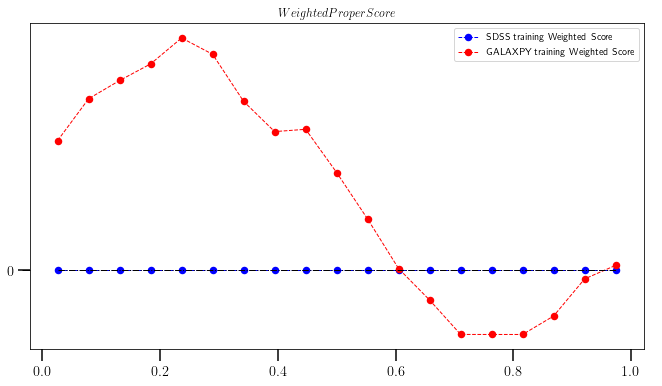

In [24]:
print('obs weighted proper score %.2e'%WeightedMedianProperScore(z_spec2, test_means_2, test_std_2, test_weights_2))
print('synthetic weighted proper score %.2e'%WeightedMedianProperScore(z_spec, test_means, test_std, test_weights))



WeightedMedianProperScore_combine0 = np.zeros(shape=(bins.shape[0]) )
WeightedMedianProperScore_obs0 = np.zeros(shape=(bins.shape[0]) )


for ind in range(bins.shape[0] - 1):
    z_spec2_bin_z2 =  z_spec2[ z_spec_digitize2  == ind + 1]
    test_means_bin_z2 =  test_means_2[ z_spec_digitize2  == ind + 1, :]
    test_std_bin_z2 =  test_std_2[ z_spec_digitize2  == ind + 1, :]
    test_weights_bin_z2 =  test_weights_2[ z_spec_digitize2  == ind + 1, :]
    
    WeightedMedianProperScore_obs0[ind] =  WeightedMedianProperScore(z_spec2_bin_z2, test_means_bin_z2, test_std_bin_z2,  test_weights_bin_z2)
    
#     z_spec_bin_z =  z_spec[ np.where(z_spec_digitize  == ind + 1) ]
#     z_phot_bin_z =  z_phot[ np.where(z_spec_digitize  == ind + 1)]
#     sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
#     outFr_combine[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)
    
    z_spec2_bin_z =  z_spec[ z_spec_digitize  == ind + 1]
    test_means_bin_z =  test_means[ z_spec_digitize  == ind + 1, :]
    test_std_bin_z =  test_std[ z_spec_digitize  == ind + 1, :]
    test_weights_bin_z =  test_weights[ z_spec_digitize  == ind + 1, :]
    
    WeightedMedianProperScore_combine0[ind] =  WeightedMedianProperScore(z_spec2_bin_z, test_means_bin_z, test_std_bin_z, test_weights_bin_z)
    
    
    
# fig, ax = plt.subplots(1,1, figsize=(11,20), sharex=True)

plt.figure(52553, figsize=(11,6))
bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, WeightedMedianProperScore_obs0[:bins.shape[0]-1], 'bo--', label = 'SDSS training ' + 'Weighted Score')
plt.plot(bincenter, WeightedMedianProperScore_combine0[:bins.shape[0]-1] , 'ro--', label = 'GALAXPY training ' + 'Weighted Score')
# ax[score_ind].set_xscale('log')
plt.plot([bincenter[0], bincenter[-1]], [0, 0], 'k-.')
plt.yscale('symlog')
leg = plt.legend()
    
plt.title(r'$Weighted Proper Score $')


In [25]:
def weightedDiff(z_spec, z_pho):
    return ( z_pho - z_spec)/(1 + z_spec)

# fig.add_subplot(212, adjustable='box', aspect=0.3)
# plt.plot( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), 'ro')
# plt.plot( (ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), 'bo')


#######################################

bins = np.linspace(0, 1, 0)
#=======
# z_spec_bin = np.histogram( (ymax2 - ymin2)*(ymin2 + y_test2), bins)[0]
# z_phot_bin = np.histogram( (ymax2 - ymin2)*(ymin2 + y_pred_new2), bins)[0]


z_spec2 = (ymax2 - ymin2)*(ymin2 + y_test2)
z_phot2 = (ymax2 - ymin2)*(ymin2 + y_pred_2)

z_spec_digitize2 = np.digitize( z_spec2, bins)

# for n in range(z_spec.size):
#     print(bins[z_spec_digitize[n]-1], "<=", z_spec[n], "<", bins[z_spec_digitize[n]])


sigmaNMAD_combine = np.zeros(shape=bins.shape[0]-1)
outFr_combine = np.zeros(shape=bins.shape[0]-1)


for ind in range(bins.shape[0] - 1):
    z_spec2_bin_z2 =  z_spec2[ z_spec_digitize2  == ind + 1]
    z_phot2_bin_z2 =  z_phot2[ z_spec_digitize2  == ind + 1]
    sigmaNMAD_combine[ind] =  sigmaNMAD(z_spec2_bin_z2, z_phot2_bin_z2)
    outFr_combine[ind] = outlierFrac(z_spec2_bin_z2, z_phot2_bin_z2, 0.15)


#####################

z_spec = (ymax - ymin)*(ymin + y_test)
z_phot = (ymax - ymin)*(ymin + y_pred)

z_spec_digitize = np.digitize( z_spec, bins)

# for n in range(z_spec.size):
#     print(bins[z_spec_digitize[n]-1], "<=", z_spec[n], "<", bins[z_spec_digitize[n]])


sigmaNMAD_obs = np.zeros(shape=binshape)
outFr_obs = np.zeros(shape=binshape)


for ind in range(bins.shape[0]- 1):
    z_spec_bin_z =  z_spec2[ np.where(z_spec_digitize  == ind + 1) ]
    z_phot_bin_z =  z_phot2[ np.where(z_spec_digitize  == ind + 1)]

    sigmaNMAD_obs[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)
    outFr_obs[ind] = outlierFrac(z_spec_bin_z, z_phot_bin_z, 0.15)


plt.figure(5232)

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, sigmaNMAD_obs[:bins.shape[0]-1], 'ro--', label = 'SDSS training')
plt.plot(bincenter, sigmaNMAD_combine[:bins.shape[0]-1] , 'bo--', label = 'GalaxPy training')
plt.xscale('log')
plt.title(r'$\sigma_{NMAD}$')
plt.legend()


plt.figure(5233)

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, outFr_obs[:bins.shape[0]-1], 'ro--', label = 'SDSS training')
plt.plot(bincenter, outFr_combine[:bins.shape[0]-1] , 'bo--', label = 'GalaxPy training')
plt.xscale('log')
plt.title('outlier fraction')
plt.legend()

sigmaNMAD_obs = np.zeros_like(bins)

for ind in range(bins.shape[0]):
    z_spec_bin_z =  z_spec2[ np.where(z_spec_digitize  == ind + 1) ]
    z_phot_bin_z =  z_phot2[ np.where(z_spec_digitize  == ind + 1)]
    sigmaNMAD_obs[ind] =  sigmaNMAD(z_spec_bin_z, z_phot_bin_z)


plt.figure(5232, figsize=(8,6))

bincenter = (bins[1:] + bins[:-1]) / 2.

plt.plot(bincenter, sigmaNMAD_obs[:-1], 'rx--', label = 'SDSS training')
plt.plot(bincenter, sigmaNMAD_combine[:-1] , 'bx--', label = 'GalaxPy training')
# plt.xscale('log')
plt.legend()

plt.ylabel(r'$\sigma_{NMAD}(z)$', fontsize=19)
plt.xlabel(r'$z_{spec}$', fontsize=19)

# plt.savefig('sNMAD_compare.png', bbox_inches='tight')

plt.show()


#######################################

# sigmaNMAD(z_spec_bin, z_phot_bin)


ValueError: negative dimensions are not allowed

In [ ]:
ifTrialPlots = False


if ifTrialPlots:
    plt.figure(22, figsize=(7, 7))

    y_pred = np.sum(pred_means_new*pred_weights_new, axis = 1)
    y_pred_std_new = np.sum(pred_std_new*pred_weights_new, axis = 1)

    # # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
    # plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
    #   ymin + y_pred_std_new), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    #
    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
      ymin + y_pred_std_new), fmt='ro', ecolor='r', ms = 3, alpha = 0.3, label = 'SDSS trained '
                                                                                 'model')



    # plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')
    # plt.ylabel(r'$z_{pred}$', fontsize = 19)
    # plt.xlabel(r'$z_{true}$', fontsize = 19)

    # plt.title('weight x mean')
    # plt.tight_layout()
    # plt.show()



## Overall mean --- weight * mean

if ifTrialPlots:

    y_pred_new2 = np.sum(pred_means_new2*pred_weights_new2, axis = 1)
    y_pred_std_new2 = np.sum(pred_std_new2*pred_weights_new2, axis = 1)

    plt.figure(22, figsize=(6,6))


    # # plt.scatter(y_test2, y_pred, facecolors='k', s = 1)
    # plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred), yerr= (ymax2 - ymin2)*(
    #   ymin2 + y_pred_std_new2), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    #
    plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_new2), yerr= (ymax2 - ymin2)*(
      ymin2 + y_pred_std_new2), fmt='bo', ecolor='b', ms = 3, alpha = 0.3, label = 'GALAXPY '
                                                                                   'trained model')


fig = plt.figure(22)

plt.xlim(0, 1)
plt.ylim(0, 1)

# plt.text(0.1, 0.9, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_obs_all, color = 'red' , size = 20)
# plt.text(0.1, 0.85, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_combine_all, color = 'blue' , size = 20)
plt.text(0.6, 0.2, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_obs_all, color = 'red' , size = 15)
plt.text(0.6, 0.1, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_combine_all, color = 'blue' , size = 15)

# plt.text(0.1, 0.9, r'GalaxPy training', color = 'red' , size = 20)
# plt.text(0.1, 0.85, r'SDSS training', color = 'blue' , size = 20)

plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')

plt.ylabel(r'$z_{phot}$', fontsize=19)
plt.xlabel(r'$z_{spec}$', fontsize=19)


# plt.ylabel(r'Photometric redshift', fontsize=19)
# plt.xlabel(r'Spectroscopic redshift', fontsize=19)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)

# plt.legend(fontsize = 'large', markerscale=3., numpoints=3)
# plt.title('weight x mean')
plt.tight_layout()

plt.axes().set_aspect('equal')

# plt.xscale('log')
# plt.yscale('log')

leg = plt.legend(fontsize = 'large', markerscale=2., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)
 

plt.savefig('phoz_compare.png', bbox_inches='tight')

plt.show()